# Exploring the Relationship Between Color and Genre in Film Poster Design Throughout the Golden Age of Hollywood (Code Supplement)

## Data Collection and Cleaning

In [3]:
import requests
from bs4 import BeautifulSoup
import os
import pandas as pd
import numpy as np
from PIL import Image
import math
import matplotlib.pyplot as plt
import re
import seaborn as sns
from sklearn.cluster import KMeans
import warnings
import webcolors
import colorsys

In [ ]:
def scrape_and_clean_films(url, start_idx, end_idx):
    response = requests.get(url)
    soup = BeautifulSoup(response.text, 'html.parser')
    film_nodes = soup.select(".text-muted.unbold , .genre , .lister-item-header a")
    film_data = [str(node) for node in film_nodes[start_idx:end_idx]]

    for i in range(0, len(film_data), 3):
        film_data[i] = re.sub("<[^>]+>", "", film_data[i])
    for i in range(1, len(film_data), 3):
        film_data[i] = re.sub("<[^>]+>|[()]", "", film_data[i])
    for i in range(2, len(film_data), 3):
        film_data[i] = re.sub("<[^>]+>|[[:space:]]+", "", film_data[i])

    return film_data

# URLs for 1930s films - page 1 and page 2
url_1930s_page1 = "https://www.imdb.com/list/ls064291644/"
url_1930s_page2 = "https://www.imdb.com/list/ls064291644/?sort=list_order,asc&st_dt=&mode=detail&page=2"
films_1930s_1 = scrape_and_clean_films(url_1930s_page1, 3, 304)
films_1930s_2 = scrape_and_clean_films(url_1930s_page2, 3, 118)

# URLs for 1940s films - page 1 and page 2
url_1940s_page1 = "https://www.imdb.com/list/ls064458124/"
url_1940s_page2 = "https://www.imdb.com/list/ls064458124/?sort=list_order,asc&st_dt=&mode=detail&page=2"
films_1940s_1 = scrape_and_clean_films(url_1940s_page1, 3, 304)
films_1940s_2 = scrape_and_clean_films(url_1940s_page2, 3, 265)

# URLs for 1950s films - page 1 and page 2
url_1950s_page1 = "https://www.imdb.com/list/ls064497029/"
url_1950s_page2 = "https://www.imdb.com/list/ls064497029/?sort=list_order,asc&st_dt=&mode=detail&page=2"
films_1950s_1 = scrape_and_clean_films(url_1950s_page1, 3, 304)
films_1950s_2 = scrape_and_clean_films(url_1950s_page2, 3, 130)

# URLs for 1960s films - page 1, page 2, and page 3
url_1960s_page1 = "https://www.imdb.com/list/ls064480080/"
url_1960s_page2 = "https://www.imdb.com/list/ls064480080/?sort=list_order,asc&st_dt=&mode=detail&page=2"
url_1960s_page3 = "https://www.imdb.com/list/ls064480080/?sort=list_order,asc&st_dt=&mode=detail&page=3"
films_1960s_1 = scrape_and_clean_films(url_1960s_page1, 3, 304)
films_1960s_2 = scrape_and_clean_films(url_1960s_page2, 3, 304)
films_1960s_3 = scrape_and_clean_films(url_1960s_page3, 3, 67)

### Cleaning Highest Grossing Films List Data

In [5]:
highest_grossing_vec = (
    films_1930s_1 + films_1930s_2 +
    films_1940s_1 + films_1940s_2 +
    films_1950s_1 + films_1950s_2 +
    films_1960s_1 + films_1960s_2 + films_1960s_3
)

highest_grossing = pd.DataFrame(
    {
        "Title": highest_grossing_vec[0::3],
        "Year": highest_grossing_vec[1::3],
        "Genre": highest_grossing_vec[2::3],
    }
)

# Creating genre fields Genre 1, Genre 2, Genre 2, Genre 3
highest_grossing["Genre1"] = None
highest_grossing["Genre2"] = None
highest_grossing["Genre3"] = None

for i in range(len(highest_grossing)):
    genre_split = highest_grossing.at[i, "Genre"].split(",")[:3]  # Split up to 3 genres
    highest_grossing.at[i, "Genre1"] = genre_split[0] if len(genre_split) > 0 else None
    highest_grossing.at[i, "Genre2"] = genre_split[1] if len(genre_split) > 1 else None
    highest_grossing.at[i, "Genre3"] = genre_split[2] if len(genre_split) > 2 else None

highest_grossing["Genre1"] = highest_grossing["Genre1"].str.replace(r'^\n', '', regex = True)
highest_grossing["Genre1"] = highest_grossing["Genre1"].str.strip()
highest_grossing["Genre2"] = highest_grossing["Genre2"].str.strip()
highest_grossing["Genre3"] = highest_grossing["Genre3"].str.strip()
highest_grossing.drop("Genre", axis = 1, inplace = True)

# Remove "Z"
highest_grossing = highest_grossing[highest_grossing["Title"] != "Z"]

# Correct the title of "Bob & Carol & Ted & Alice"
highest_grossing.loc[highest_grossing["Title"] == 
                     "Bob &amp; Carol &amp; Ted &amp; Alice", 
                     "Title"] = "Bob & Carol & Ted & Alice"

# Correct the title of It's a Mad, Mad, Mad, Mad, World"
highest_grossing.loc[highest_grossing["Title"] == 
                     "It's a Mad Mad Mad Mad World", "Title"] = "It's a Mad Mad Mad Mad World"

# Correct year formatting
highest_grossing.loc[highest_grossing["Title"] == "Anna Christie", "Year"] = "1930"
highest_grossing.loc[highest_grossing["Title"] == "Grand Hotel", "Year"] = "1932"
highest_grossing.loc[highest_grossing["Title"] == "The Egg and I", "Year"] = "1947"
highest_grossing.loc[highest_grossing["Title"] == "The Trip", "Year"] = "1967"
highest_grossing["Year"] = highest_grossing["Year"].astype(int)

# Order by year
highest_grossing = highest_grossing.sort_values(by = "Year")


### Loading Academy Award Best Picture List Data

In [6]:
best_picture_nom_page1 = "https://www.imdb.com/list/ls098569847/?sort=release_date,asc&st_dt=&mode=detail&page=1"
best_picture_nom_1 = scrape_and_clean_films(best_picture_nom_page1, 33, 304)

best_picture_nom_page2 = "https://www.imdb.com/list/ls098569847/?sort=release_date,asc&st_dt=&mode=detail&page=2"
best_picture_nom_2 = scrape_and_clean_films(best_picture_nom_page2, 3, 304)

best_picture_nom_page3 = "https://www.imdb.com/list/ls098569847/?sort=release_date,asc&st_dt=&mode=detail&page=3"
best_picture_nom_3 = scrape_and_clean_films(best_picture_nom_page3, 3, 216)

### Cleaning Academy Award Best Picture List Data

In [7]:
best_picture_nom_vec = best_picture_nom_1 + best_picture_nom_2 + best_picture_nom_3

best_picture_nom = pd.DataFrame({
    "Title": best_picture_nom_vec[0::3],
    "Year": best_picture_nom_vec[1::3],
    "Genre": best_picture_nom_vec[2::3]
})

# Creating genre fields Genre 1, Genre 2, Genre 2, Genre 3
best_picture_nom["Genre1"] = None
best_picture_nom["Genre2"] = None
best_picture_nom["Genre3"] = None

for i in range(len(best_picture_nom)):
    genre_split = best_picture_nom.at[i, "Genre"].split(",")[:3]  # Split up to 3 genres
    best_picture_nom.at[i, "Genre1"] = genre_split[0] if len(genre_split) > 0 else None
    best_picture_nom.at[i, "Genre2"] = genre_split[1] if len(genre_split) > 1 else None
    best_picture_nom.at[i, "Genre3"] = genre_split[2] if len(genre_split) > 2 else None

best_picture_nom["Genre1"] = best_picture_nom["Genre1"].str.replace(r'^\n', '', regex = True)
best_picture_nom["Genre1"] = best_picture_nom["Genre1"].str.strip()
best_picture_nom["Genre2"] = best_picture_nom["Genre2"].str.strip()
best_picture_nom["Genre3"] = best_picture_nom["Genre3"].str.strip()
best_picture_nom.drop("Genre", axis = 1, inplace = True)

# Remove the second instance of "Casablanca"
best_picture_nom = best_picture_nom.drop(121)

# Remove films with titles "The Grand Illusion" and "Z"
best_picture_nom = best_picture_nom[~best_picture_nom["Title"].isin(["The Grand Illusion", "Z"])]

# Change the year of "The Treasure of the Sierra Madre" to 1948
best_picture_nom.at[150, "Year"] = "1948"

# Change the year of "Room at the Top" to 1959
best_picture_nom.at[205, "Year"] = "1959"

# Correct year formatting
best_picture_nom.loc[best_picture_nom["Title"] == "The Champ", "Year"] = "1931"
best_picture_nom.loc[best_picture_nom["Title"] == "Grand Hotel", "Year"] = "1932"
best_picture_nom["Year"] = best_picture_nom["Year"].astype(int)

# Correct the title of "The Russians Are Coming, the Russians Are Coming"
best_picture_nom.at[241, "Title"] = "The Russians Are Coming, the Russians Are Coming"

### Loading MMP Dataset

In [9]:
mmp = pd.read_csv("D:/Users/valeri.vankov/Downloads/MMP Unique Titles.csv")
mmp = mmp.where(pd.notna(mmp), None)
mmp["Year"] = mmp["Year"].astype(int)

### Creating Combined Dataset

In [10]:
combined = pd.concat([highest_grossing, best_picture_nom, mmp])
combined['Title'] = combined["Title"].str.replace("[?:]", "", regex = True)
combined['Title'] = combined['Title'].str.replace('’', "'", regex = False)
combined["Year"] = combined["Year"].astype(int)
combined = combined.drop_duplicates()
combined = combined.sort_values(by = ["Year", "Title"])
combined.reset_index(drop = True, inplace = True)
combined["Compound Title"] = combined["Title"] + " (" + combined["Year"].astype(str) + ")"

### Extracting Film Posters

In [367]:
titles = combined["Title"]
years = combined["Year"]
titles2 = titles.replace(" ", "%20")
n = len(titles2)

for i in range(n):
    query = f"{titles2[i]} {years[i]} IMDb"
    query = query.replace(" ", "%20")
    url = f"http://www.google.com/search?q={query}&tbm=isch"

    try:
        response = requests.get(url)
        soup = BeautifulSoup(response.text, "html.parser")

        image_tags = soup.find_all("img")
        if len(image_tags) > 1:
            image_url = image_tags[1]["src"]

            filename = f"{titles2[i]} ({years[i]}).png"

            with open(os.path.join("D:/Users/valeri.vankov/Downloads", filename), "wb") as image_file:
                response = requests.get(image_url)
                image_file.write(response.content)
    except requests.exceptions.RequestException as e:
        print(f"HTTP request error for {titles2[i]} ({years[i]}) IMDb: {e}")
    except Exception as e:
        print(f"Error for {titles2[i]} ({years[i]}) IMDb: {e}")

HTTP request error for A Star Is Born (1937) IMDb: Invalid URL '//www.gstatic.com/search_trustx/visibility_off_icon_p600-fc0fcd3cc6b30b7d85289bc9f0a7298a.png': No scheme supplied. Perhaps you meant https:////www.gstatic.com/search_trustx/visibility_off_icon_p600-fc0fcd3cc6b30b7d85289bc9f0a7298a.png?
HTTP request error for Fantasia (1940) IMDb: Invalid URL '//www.gstatic.com/search_trustx/visibility_off_icon_p600-fc0fcd3cc6b30b7d85289bc9f0a7298a.png': No scheme supplied. Perhaps you meant https:////www.gstatic.com/search_trustx/visibility_off_icon_p600-fc0fcd3cc6b30b7d85289bc9f0a7298a.png?
Error for Who Done It? (1942) IMDb: [Errno 22] Invalid argument: 'D:/Users/valeri.vankov/Downloads\\Who Done It? (1942).png'
HTTP request error for Between Heaven and Hell (1956) IMDb: Invalid URL '//www.gstatic.com/search_trustx/visibility_off_icon_p600-fc0fcd3cc6b30b7d85289bc9f0a7298a.png': No scheme supplied. Perhaps you meant https:////www.gstatic.com/search_trustx/visibility_off_icon_p600-fc0fcd3

The image resquests that produced error correspond to the following titles: *A Star Is Born* (1937), *Fantasia* (1940), *Who Done It?* (1942), *Between Heaven and Hell* (1956), *Will Success Spoil Rock Hunter?* (1957), *Splendor in the Grass* (1961), *That Touch of Mink* (1962), *What Ever Happened to Baby Jane?* (1962), *Man's Favorite Sport?* (1964), *Our Man Flint* (1966), *Who's Afraid of Virginia Woolf?* (1966), *Hello, Dolly!* (1969), *The Stewardesses* (1969), *They Shoot Horses, Don't They?* (1969). The files for *Smash-Up: The Story of a Woman* (1947), *Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb* (1964), *The Bible: In the Beginning...* (1966), and *2001: A Space Odyssey* (1968) are also invalid, so we are going to retrieve the posters for these films manually. Note that since a file name cannot contain certain characters (namely, \, /,:,*,?,",<,>, and |), any instances of such characters in the original titles have been removed.

### Creating Image Encodings for Each Title

In [11]:
combined["Image"] = None
folder_path = "D:/Users/valeri.vankov/Downloads/MMP Posters"

for index, row in combined.iterrows():
    compound_title = row["Compound Title"]
    image_path = os.path.join(folder_path, f"{compound_title}.png")
    img = Image.open(image_path)
    img = img.resize((256, 256))
    combined.at[index, "Image"] = np.array(img)

## Color Extraction

### Finding Main Color

In [12]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")

    combined["Main Color (RGB)"] = None

    for i in range(combined.shape[0]):
        image_rgb = combined["Image"].iloc[i]
        pixels = np.array(image_rgb).reshape(-1, 3)
        num_colors = 5
        kmeans = KMeans(n_clusters=num_colors, random_state=0)
        kmeans.fit(pixels)
        cluster_centers = kmeans.cluster_centers_
        dominant_color_index = np.argmax(np.bincount(kmeans.labels_))
        dominant_color = cluster_centers[dominant_color_index]
        combined.at[i, "Main Color (RGB)"] = list(map(int, dominant_color))

### Converting from RGB to HSL

In [13]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")

    def rgb_to_hsl(rgb):
        r, g, b = [x / 255.0 for x in rgb]
        h, l, s = colorsys.rgb_to_hls(r, g, b)
        h = round(h * 360)
        s = round(s * 100)
        l = round(l * 100)
        return [h, s, l]

    combined["Main Color (HSL)"] = None

    for i in range(combined.shape[0]):
        combined["Main Color (HSL)"][i] = rgb_to_hsl(combined["Main Color (RGB)"][i])

### Classifying all colors into one of 11 types

In [14]:
def hsl_to_name(h, s, l):
    options = ["blue", "purple", "pink", "red", "orange", "yellow", "green"]

    if l >= 95:
        return "white"
    elif l <= 5:
        return "black"
    elif s <= 10:
        return "gray"
    elif (h >= 20) & (h <= 40) & (s <= 70):
        return "brown"

    # Convert hue to x value
    x = ((h + 180) % 360) / 60.0
    match = match_hue(x)
    return options[match]

def match_hue(x):
    return int(math.floor(7 / (1 + math.pow(math.e, (-1.1 * (x - 3))))))

In [15]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")

    combined["Simplified Color Name"] = None

    for i in range(combined.shape[0]):
        combined["Simplified Color Name"][i] = hsl_to_name(combined["Main Color (HSL)"][i][0], 
                                                            combined["Main Color (HSL)"][i][1],
                                                            combined["Main Color (HSL)"][i][2])
        
    combined["Simplified Color (RGB)"] = None

    for i in range(combined.shape[0]):
        combined["Simplified Color (RGB)"][i] = list(webcolors.name_to_rgb(combined["Simplified Color Name"][i]))

## Data Analysis and Visualization

### Visualizing all films

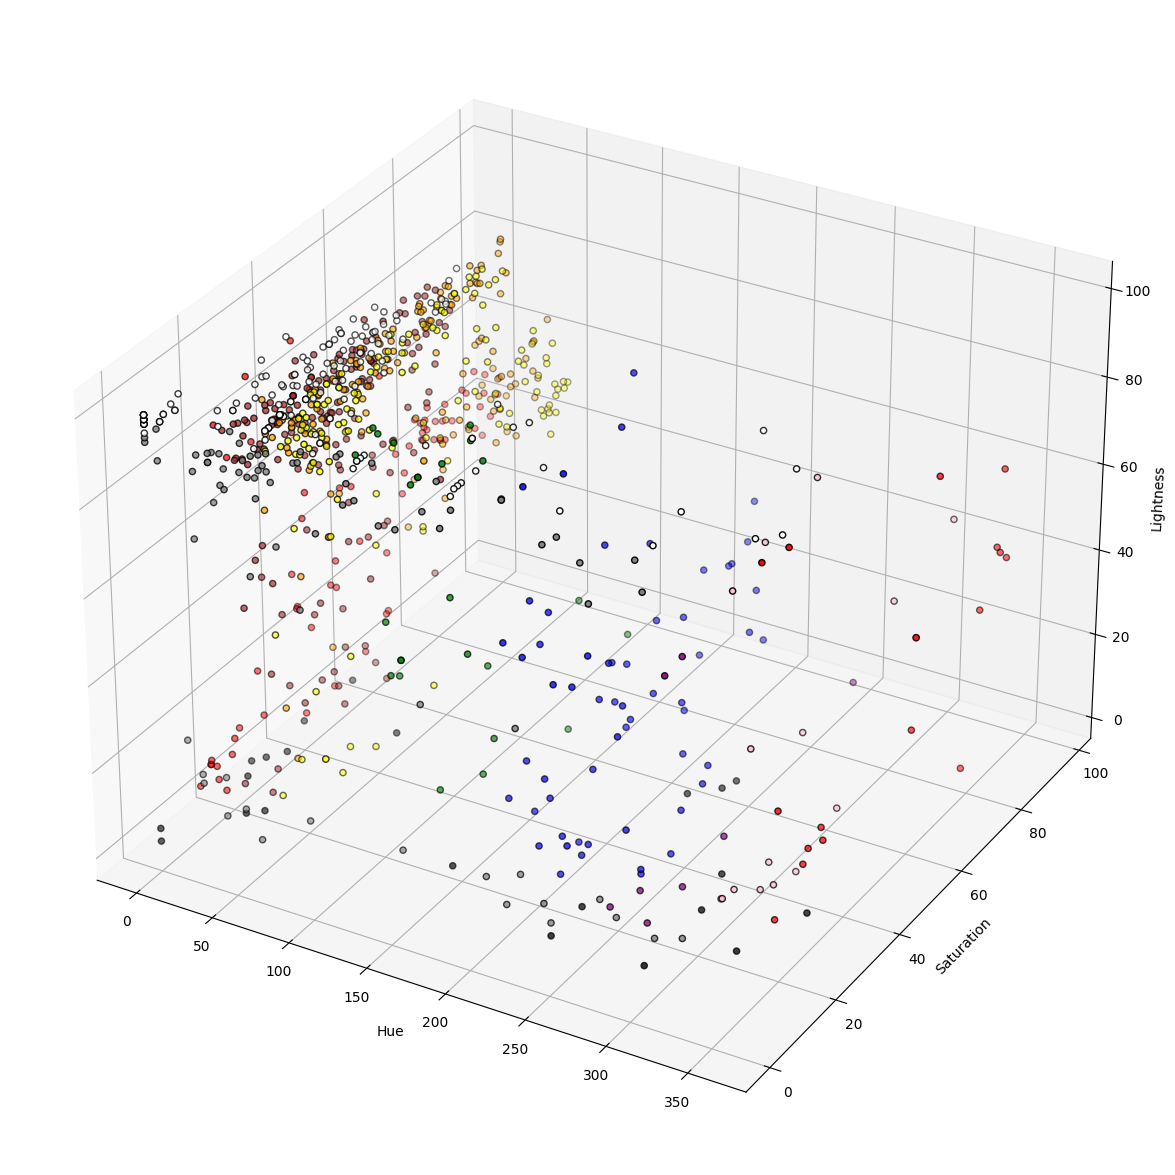

In [48]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")

    hue_values = pd.DataFrame(combined['Main Color (HSL)'].tolist(), columns=['Hue', 'Saturation', 'Lightness'])['Hue']
    saturation_values = pd.DataFrame(combined['Main Color (HSL)'].tolist(), columns=['Hue', 'Saturation', 'Lightness'])['Saturation']
    lightness_values = pd.DataFrame(combined['Main Color (HSL)'].tolist(), columns=['Hue', 'Saturation', 'Lightness'])['Lightness']

    color_names = combined["Simplified Color Name"]

    # Map HSL values to color names
    color_names = [hsl_to_name(h, s, l) for h, s, l in zip(hue_values, saturation_values, lightness_values)]

    # Map color names to numerical values for plotting
    color_mapping = {"blue": 0, "purple": 1, "pink": 2, "red": 3, "orange": 4, "yellow": 5, "green": 6, "brown": 7,
                    "black": 8, "white": 9, "gray": 10}
    colors = [color_mapping[name] for name in color_names]

    # Create a 3D scatter plot with colors based on color names
    fig = plt.figure(figsize=(15, 15))
    ax = fig.add_subplot(111, projection='3d')
    scatter = ax.scatter(hue_values, saturation_values, lightness_values, c=color_names, cmap="viridis", marker='o', s=20, edgecolor='black')

    # Customize plot appearance
    ax.set_xlabel('Hue')
    ax.set_ylabel('Saturation')
    ax.set_zlabel('Lightness')

(-1.0999967575663159,
 1.099999063167048,
 -1.0999975773163164,
 1.0999998846341104)

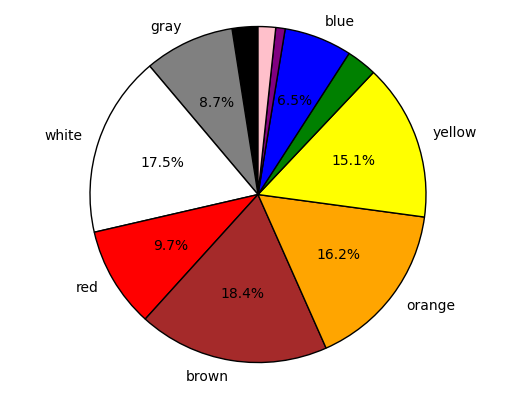

In [49]:
labels = ['black', 'gray', 'white', 'red', 'brown', 'orange', 'yellow', 'green', 'blue', 'purple', 'pink']
sizes = [len(combined[combined["Simplified Color Name"] == color]) for color in labels]
total_size = sum(sizes)

patches, texts, autotexts = plt.pie(
    x=sizes,
    labels=['' if (size / total_size) * 100 < 5 else label for label, size in zip(labels, sizes)],
    autopct='%1.1f%%',
    startangle=90,
    colors=labels,
    wedgeprops=dict(edgecolor='black', linewidth=1)
)

for autotext in autotexts:
    autotext.set_visible(True if float(autotext.get_text().split('\n')[-1][:-1]) >= 5 else False)

plt.axis('equal')

### Visualizing drama films

In [50]:
drama_films = combined[(combined["Genre1"] == "Drama") | 
                         (combined["Genre2"] == "Drama") | 
                         (combined["Genre3"] == "Drama")]

(-1.0999976292822349,
 1.0999985491081197,
 -1.099997050113396,
 1.0999998595292093)

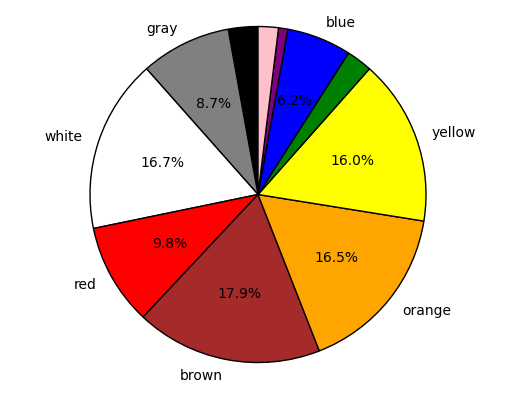

In [51]:
labels = ['black', 'gray', 'white', 'red', 'brown', 'orange', 'yellow', 'green', 'blue', 'purple', 'pink']
sizes = [len(drama_films[drama_films["Simplified Color Name"] == color]) for color in labels]
total_size = sum(sizes)

patches, texts, autotexts = plt.pie(
    x=sizes,
    labels=['' if (size / total_size) * 100 < 5 else label for label, size in zip(labels, sizes)],
    autopct='%1.1f%%',
    startangle=90,
    colors=labels,
    textprops=dict(color='black'),
    wedgeprops=dict(edgecolor='black', linewidth=1)
)

for autotext, color in zip(autotexts, labels):
    autotext.set_visible(True if float(autotext.get_text().split('\n')[-1][:-1]) >= 5 else False)
    if color == 'black':
        autotext.set_color('white')

plt.axis('equal')

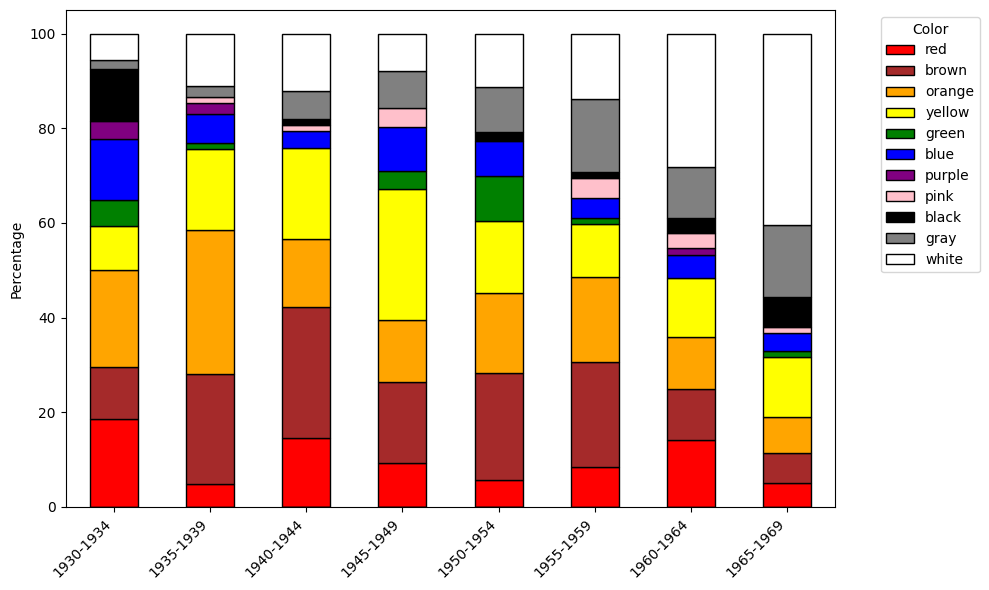

In [53]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")

    bin_edges = list(range(1930, 1971, 5))
    bin_labels = [f'{start}-{start+4}' for start in range(1930, 1970, 5)]
    drama_films['5-Year Period'] = pd.cut(drama_films['Year'], bins=bin_edges, labels=bin_labels, right=False)
    color_counts = drama_films.groupby(['5-Year Period', 'Simplified Color Name']).size().unstack().fillna(0)
    color_order = ['red', 'brown', 'orange', 'yellow', 'green', 'blue', 'purple', 'pink', 'black', 'gray', 'white']
    color_counts = color_counts[color_order]
    color_percentages = color_counts.div(color_counts.sum(axis=1), axis=0) * 100
    fig, ax = plt.subplots(figsize=(10, 6))
    color_percentages.plot(kind='bar', stacked=True, color=color_order, edgecolor='black', ax=ax)
    plt.xlabel('')
    plt.ylabel('Percentage')
    plt.legend(title='Color', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()

### Visualizing romance films

In [54]:
romance_films = combined[(combined["Genre1"] == "Romance") | 
                         (combined["Genre2"] == "Romance") | 
                         (combined["Genre3"] == "Romance")]

(-1.0999997360442708,
 1.0999971041117502,
 -1.0999939406206094,
 1.0999997114581244)

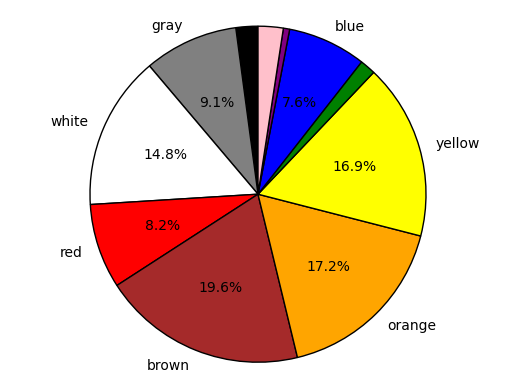

In [56]:
labels = ['black', 'gray', 'white', 'red', 'brown', 'orange', 'yellow', 'green', 'blue', 'purple', 'pink']
sizes = [len(romance_films[romance_films["Simplified Color Name"] == color]) for color in labels]
total_size = sum(sizes)

patches, texts, autotexts = plt.pie(
    x=sizes,
    labels=['' if (size / total_size) * 100 < 5 else label for label, size in zip(labels, sizes)],
    autopct='%1.1f%%',
    startangle=90,
    colors=labels,
    textprops=dict(color='black'),
    wedgeprops=dict(edgecolor='black', linewidth=1)
)

for autotext, color in zip(autotexts, labels):
    autotext.set_visible(True if float(autotext.get_text().split('\n')[-1][:-1]) >= 5 else False)
    if color == 'black':
        autotext.set_color('white')

plt.axis('equal')

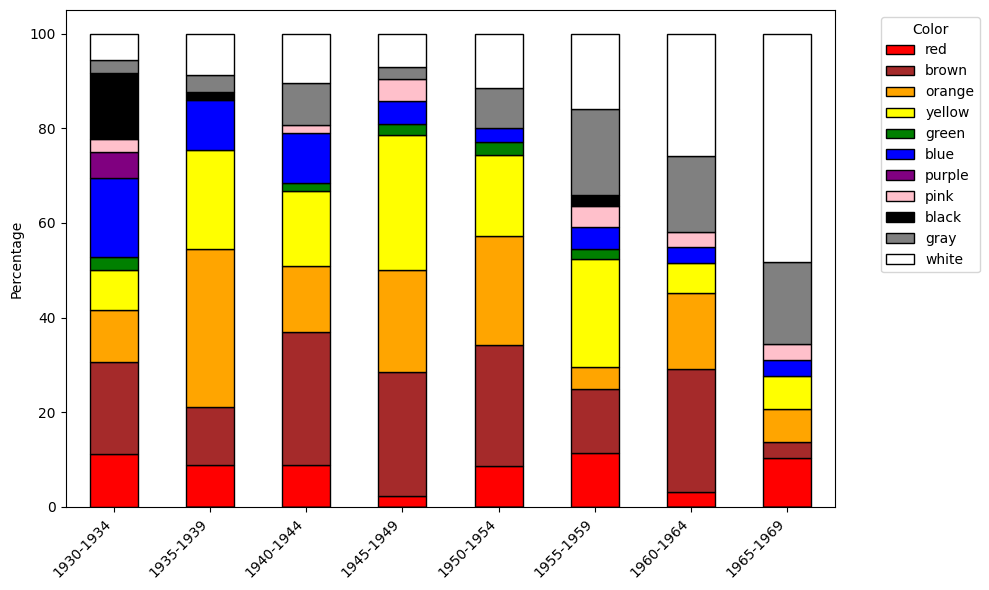

In [57]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")

    bin_edges = list(range(1930, 1971, 5))
    bin_labels = [f'{start}-{start+4}' for start in range(1930, 1970, 5)]
    romance_films['5-Year Period'] = pd.cut(romance_films['Year'], bins=bin_edges, labels=bin_labels, right=False)
    color_counts = romance_films.groupby(['5-Year Period', 'Simplified Color Name']).size().unstack().fillna(0)
    color_order = ['red', 'brown', 'orange', 'yellow', 'green', 'blue', 'purple', 'pink', 'black', 'gray', 'white']
    color_counts = color_counts[color_order]
    color_percentages = color_counts.div(color_counts.sum(axis=1), axis=0) * 100
    fig, ax = plt.subplots(figsize=(10, 6))
    color_percentages.plot(kind='bar', stacked=True, color=color_order, edgecolor='black', ax=ax)
    plt.xlabel('')
    plt.ylabel('Percentage')
    plt.legend(title='Color', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()

### Visualizing comedy films

In [59]:
comedy_films = combined[(combined["Genre1"] == "Comedy") | 
                         (combined["Genre2"] == "Comedy") | 
                         (combined["Genre3"] == "Comedy")]

(-1.0999945001509221,
 1.0999992888799648,
 -1.0999939471442264,
 1.0999997117687728)

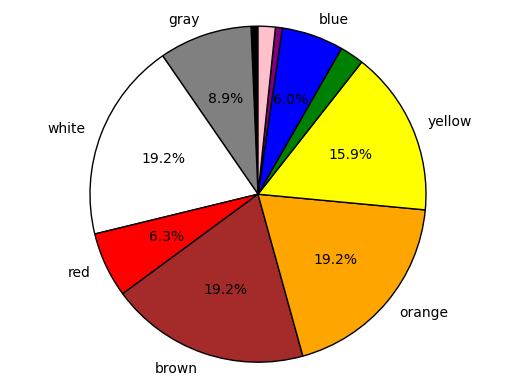

In [60]:
labels = ['black', 'gray', 'white', 'red', 'brown', 'orange', 'yellow', 'green', 'blue', 'purple', 'pink']
sizes = [len(comedy_films[comedy_films["Simplified Color Name"] == color]) for color in labels]
total_size = sum(sizes)

patches, texts, autotexts = plt.pie(
    x=sizes,
    labels=['' if (size / total_size) * 100 < 5 else label for label, size in zip(labels, sizes)],
    autopct='%1.1f%%',
    startangle=90,
    colors=labels,
    textprops=dict(color='black'),
    wedgeprops=dict(edgecolor='black', linewidth=1)
)

for autotext, color in zip(autotexts, labels):
    autotext.set_visible(True if float(autotext.get_text().split('\n')[-1][:-1]) >= 5 else False)
    if color == 'black':
        autotext.set_color('white')

plt.axis('equal')

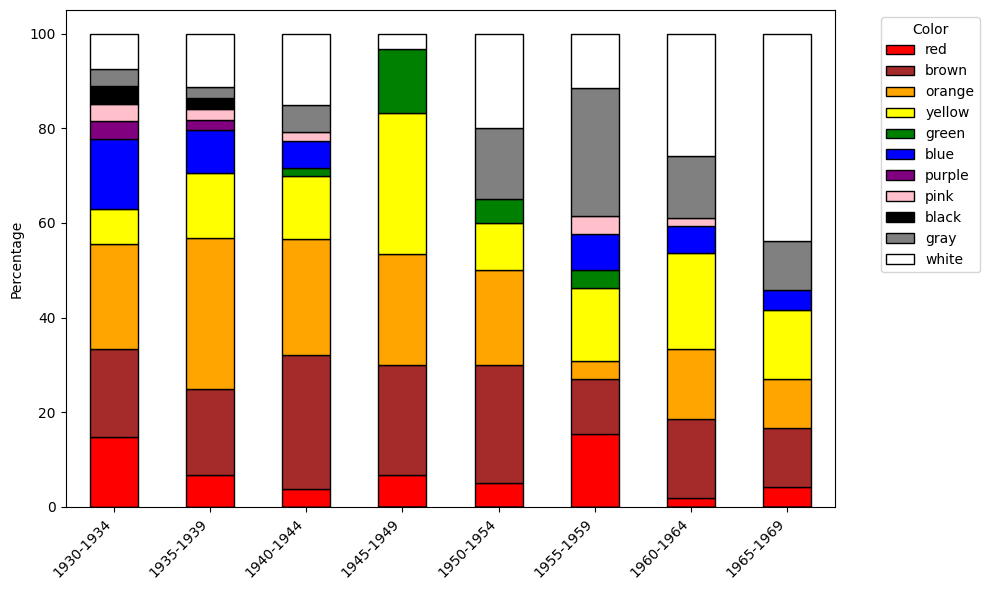

In [61]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")

    bin_edges = list(range(1930, 1971, 5))
    bin_labels = [f'{start}-{start+4}' for start in range(1930, 1970, 5)]
    comedy_films['5-Year Period'] = pd.cut(comedy_films['Year'], bins=bin_edges, labels=bin_labels, right=False)
    color_counts = comedy_films.groupby(['5-Year Period', 'Simplified Color Name']).size().unstack().fillna(0)
    color_order = ['red', 'brown', 'orange', 'yellow', 'green', 'blue', 'purple', 'pink', 'black', 'gray', 'white']
    color_counts = color_counts[color_order]
    color_percentages = color_counts.div(color_counts.sum(axis=1), axis=0) * 100
    fig, ax = plt.subplots(figsize=(10, 6))
    color_percentages.plot(kind='bar', stacked=True, color=color_order, edgecolor='black', ax=ax)
    plt.xlabel('')
    plt.ylabel('Percentage')
    plt.legend(title='Color', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()

### Visualizing musical films

In [63]:
musical_films = combined[(combined["Genre1"] == "Musical") | 
                         (combined["Genre2"] == "Musical") | 
                         (combined["Genre3"] == "Musical")]

(-1.0999958917935369,
 1.099999698718363,
 -1.0999977937018661,
 1.0999998949381842)

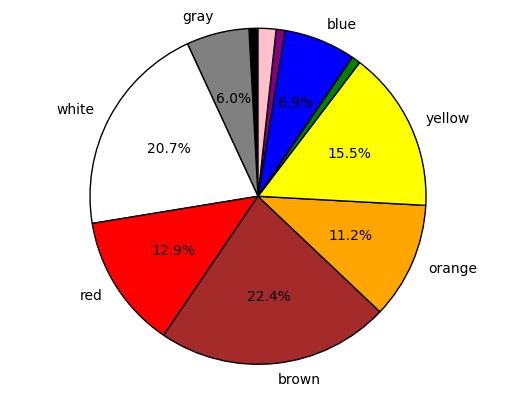

In [64]:
labels = ['black', 'gray', 'white', 'red', 'brown', 'orange', 'yellow', 'green', 'blue', 'purple', 'pink']
sizes = [len(musical_films[musical_films["Simplified Color Name"] == color]) for color in labels]
total_size = sum(sizes)

patches, texts, autotexts = plt.pie(
    x=sizes,
    labels=['' if (size / total_size) * 100 < 5 else label for label, size in zip(labels, sizes)],
    autopct='%1.1f%%',
    startangle=90,
    colors=labels,
    textprops=dict(color='black'),
    wedgeprops=dict(edgecolor='black', linewidth=1)
)

for autotext, color in zip(autotexts, labels):
    autotext.set_visible(True if float(autotext.get_text().split('\n')[-1][:-1]) >= 5 else False)
    if color == 'black':
        autotext.set_color('white')

plt.axis('equal')

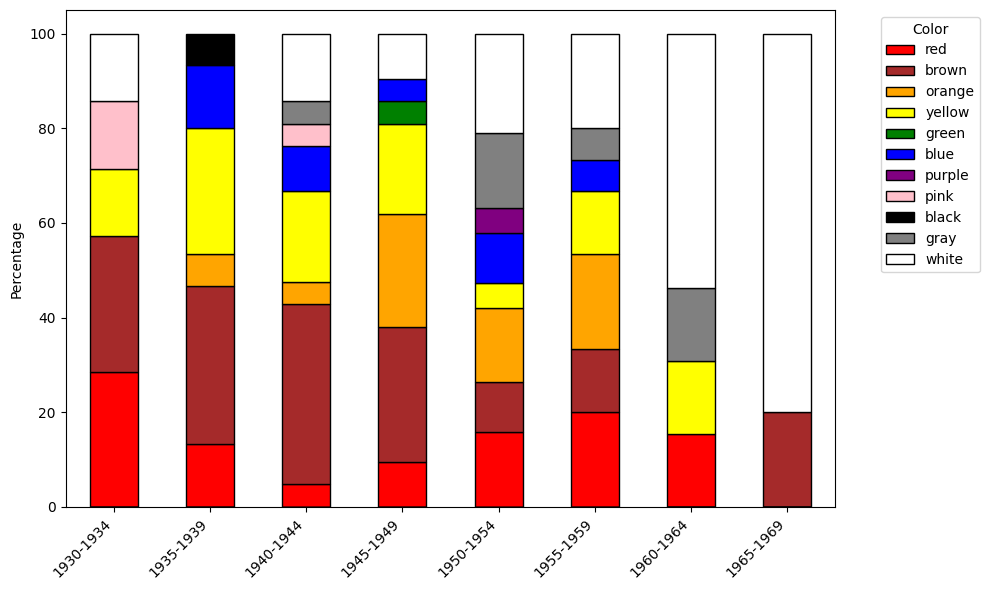

In [65]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")

    bin_edges = list(range(1930, 1971, 5))
    bin_labels = [f'{start}-{start+4}' for start in range(1930, 1970, 5)]
    musical_films['5-Year Period'] = pd.cut(musical_films['Year'], bins=bin_edges, labels=bin_labels, right=False)
    color_counts = musical_films.groupby(['5-Year Period', 'Simplified Color Name']).size().unstack().fillna(0)
    color_order = ['red', 'brown', 'orange', 'yellow', 'green', 'blue', 'purple', 'pink', 'black', 'gray', 'white']
    color_counts = color_counts[color_order]
    color_percentages = color_counts.div(color_counts.sum(axis=1), axis=0) * 100
    fig, ax = plt.subplots(figsize=(10, 6))
    color_percentages.plot(kind='bar', stacked=True, color=color_order, edgecolor='black', ax=ax)
    plt.xlabel('')
    plt.ylabel('Percentage')
    plt.legend(title='Color', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()

### Visualizing film-noir films

In [66]:
film_noir_films = combined[(combined["Genre1"] == "Film-Noir") | 
                         (combined["Genre2"] == "Film-Noir") | 
                         (combined["Genre3"] == "Film-Noir")]

(-1.0999956451344752, 1.099983275614545, -1.099998949921436, 1.099999949996259)

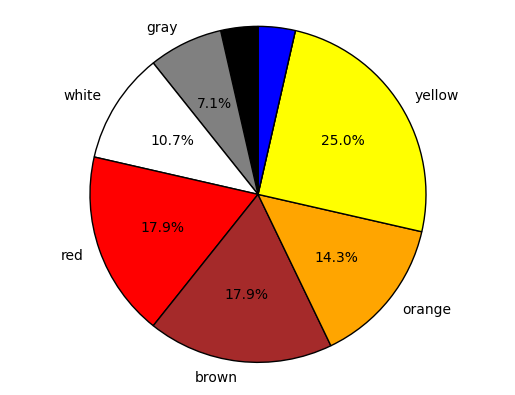

In [67]:
labels = ['black', 'gray', 'white', 'red', 'brown', 'orange', 'yellow', 'green', 'blue', 'purple', 'pink']
sizes = [len(film_noir_films[film_noir_films["Simplified Color Name"] == color]) for color in labels]
total_size = sum(sizes)

patches, texts, autotexts = plt.pie(
    x=sizes,
    labels=['' if (size / total_size) * 100 < 5 else label for label, size in zip(labels, sizes)],
    autopct='%1.1f%%',
    startangle=90,
    colors=labels,
    textprops=dict(color='black'),
    wedgeprops=dict(edgecolor='black', linewidth=1)
)

for autotext, color in zip(autotexts, labels):
    autotext.set_visible(True if float(autotext.get_text().split('\n')[-1][:-1]) >= 5 else False)
    if color == 'black':
        autotext.set_color('white')

plt.axis('equal')

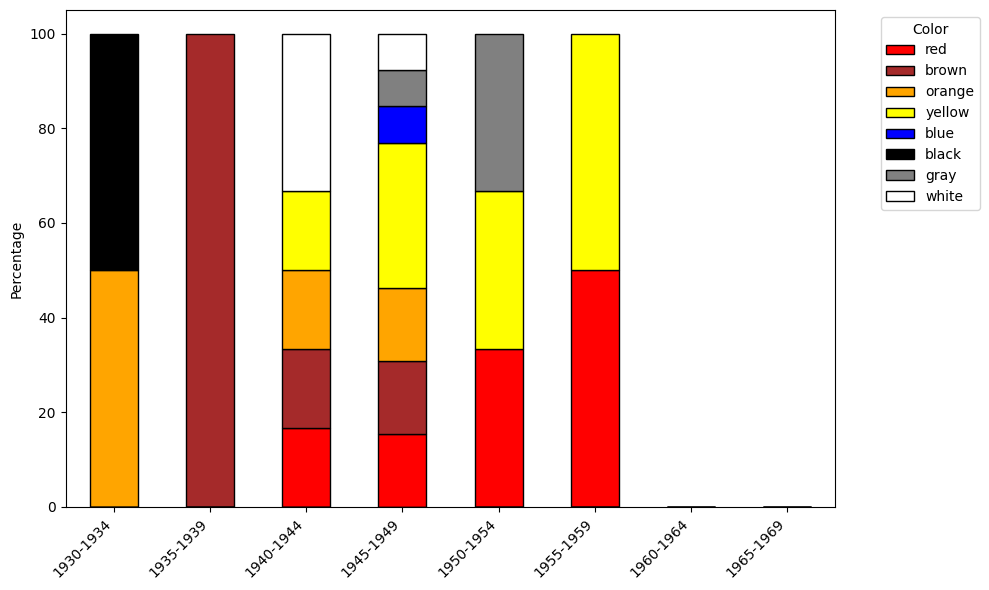

In [69]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")

    bin_edges = list(range(1930, 1971, 5))
    bin_labels = [f'{start}-{start+4}' for start in range(1930, 1970, 5)]
    film_noir_films['5-Year Period'] = pd.cut(film_noir_films['Year'], bins=bin_edges, labels=bin_labels, right=False)
    color_counts = film_noir_films.groupby(['5-Year Period', 'Simplified Color Name']).size().unstack().fillna(0)
    color_order = ['red', 'brown', 'orange', 'yellow', 'blue', 'black', 'gray', 'white']
    color_counts = color_counts[color_order]
    color_percentages = color_counts.div(color_counts.sum(axis=1), axis=0) * 100
    fig, ax = plt.subplots(figsize=(10, 6))
    color_percentages.plot(kind='bar', stacked=True, color=color_order, edgecolor='black', ax=ax)
    plt.xlabel('')
    plt.ylabel('Percentage')
    plt.legend(title='Color', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()

### Visualizing horror films

In [70]:
horror_films = combined[(combined["Genre1"] == "Horror") | 
                         (combined["Genre2"] == "Horror") | 
                         (combined["Genre3"] == "Horror")]

(-1.099998918338935,
 1.0999999088086037,
 -1.0999999796094357,
 1.0999999990290208)

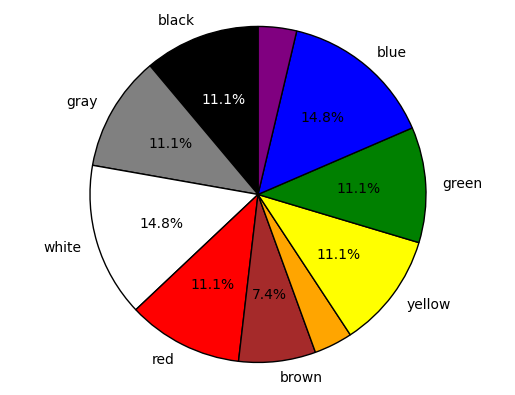

In [71]:
labels = ['black', 'gray', 'white', 'red', 'brown', 'orange', 'yellow', 'green', 'blue', 'purple', 'pink']
sizes = [len(horror_films[horror_films["Simplified Color Name"] == color]) for color in labels]
total_size = sum(sizes)

patches, texts, autotexts = plt.pie(
    x=sizes,
    labels=['' if (size / total_size) * 100 < 5 else label for label, size in zip(labels, sizes)],
    autopct='%1.1f%%',
    startangle=90,
    colors=labels,
    textprops=dict(color='black'),
    wedgeprops=dict(edgecolor='black', linewidth=1)
)

for autotext, color in zip(autotexts, labels):
    autotext.set_visible(True if float(autotext.get_text().split('\n')[-1][:-1]) >= 5 else False)
    if color == 'black':
        autotext.set_color('white')

plt.axis('equal')

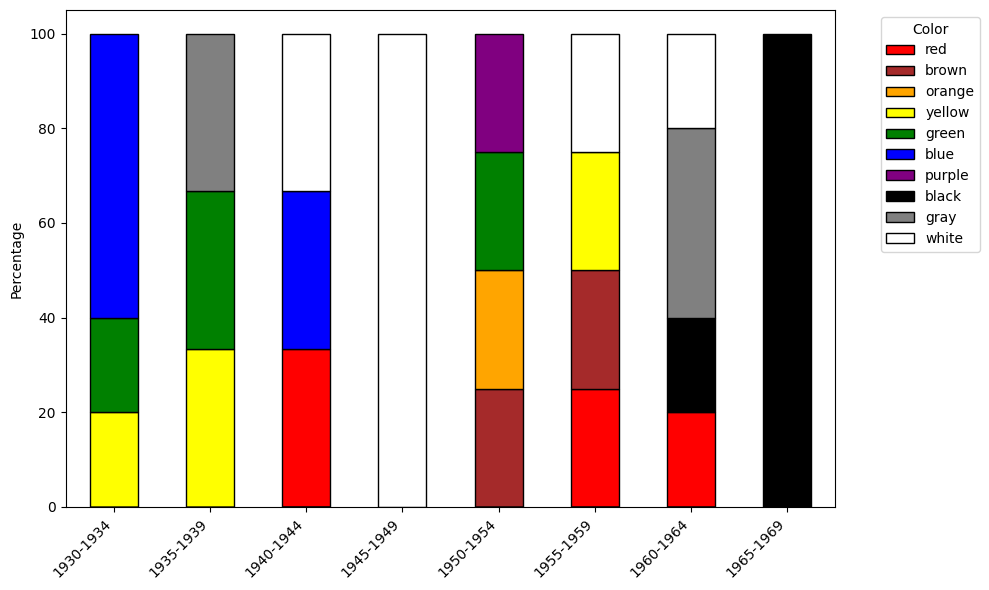

In [73]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")

    bin_edges = list(range(1930, 1971, 5))
    bin_labels = [f'{start}-{start+4}' for start in range(1930, 1970, 5)]
    horror_films['5-Year Period'] = pd.cut(horror_films['Year'], bins=bin_edges, labels=bin_labels, right=False)
    color_counts = horror_films.groupby(['5-Year Period', 'Simplified Color Name']).size().unstack().fillna(0)
    color_order = ['red', 'brown', 'orange', 'yellow', 'green', 'blue', 'purple', 'black', 'gray', 'white']
    color_counts = color_counts[color_order]
    color_percentages = color_counts.div(color_counts.sum(axis=1), axis=0) * 100
    fig, ax = plt.subplots(figsize=(10, 6))
    color_percentages.plot(kind='bar', stacked=True, color=color_order, edgecolor='black', ax=ax)
    plt.xlabel('')
    plt.ylabel('Percentage')
    plt.legend(title='Color', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()

### Visualizing sci-fi films

In [77]:
sci_fi_films = combined[(combined["Genre1"] == "Sci-Fi") | 
                         (combined["Genre2"] == "Sci-Fi") | 
                         (combined["Genre3"] == "Sci-Fi")]

(-1.0999992985061582, 1.0999997621782123, -1.1, 1.1)

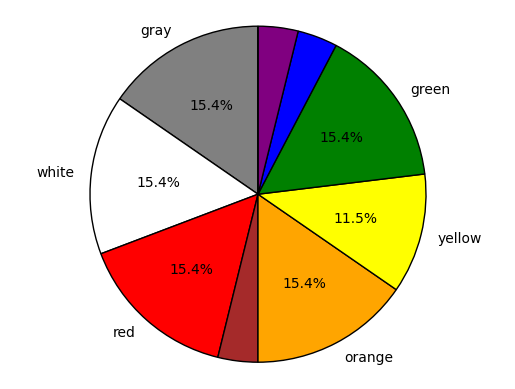

In [78]:
labels = ['black', 'gray', 'white', 'red', 'brown', 'orange', 'yellow', 'green', 'blue', 'purple', 'pink']
sizes = [len(sci_fi_films[sci_fi_films["Simplified Color Name"] == color]) for color in labels]
total_size = sum(sizes)

patches, texts, autotexts = plt.pie(
    x=sizes,
    labels=['' if (size / total_size) * 100 < 5 else label for label, size in zip(labels, sizes)],
    autopct='%1.1f%%',
    startangle=90,
    colors=labels,
    textprops=dict(color='black'),
    wedgeprops=dict(edgecolor='black', linewidth=1)
)

for autotext, color in zip(autotexts, labels):
    autotext.set_visible(True if float(autotext.get_text().split('\n')[-1][:-1]) >= 5 else False)
    if color == 'black':
        autotext.set_color('white')

plt.axis('equal')

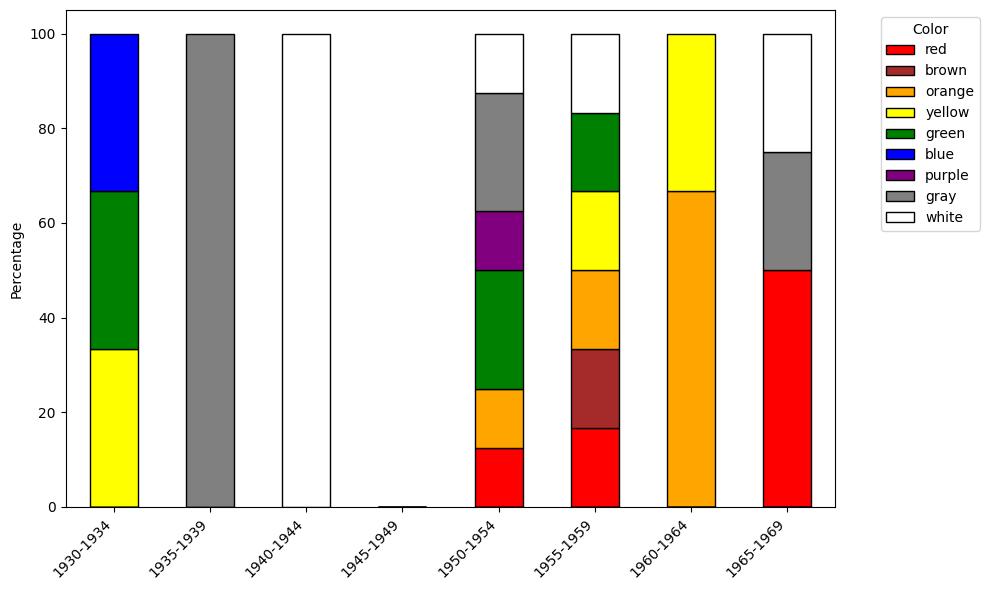

In [80]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")

    bin_edges = list(range(1930, 1971, 5))
    bin_labels = [f'{start}-{start+4}' for start in range(1930, 1970, 5)]
    sci_fi_films['5-Year Period'] = pd.cut(sci_fi_films['Year'], bins=bin_edges, labels=bin_labels, right=False)
    color_counts = sci_fi_films.groupby(['5-Year Period', 'Simplified Color Name']).size().unstack().fillna(0)
    color_order = ['red', 'brown', 'orange', 'yellow', 'green', 'blue', 'purple', 'gray', 'white']
    color_counts = color_counts[color_order]
    color_percentages = color_counts.div(color_counts.sum(axis=1), axis=0) * 100
    fig, ax = plt.subplots(figsize=(10, 6))
    color_percentages.plot(kind='bar', stacked=True, color=color_order, edgecolor='black', ax=ax)
    plt.xlabel('')
    plt.ylabel('Percentage')
    plt.legend(title='Color', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()

## Comparing mean saturation and lightness across genres

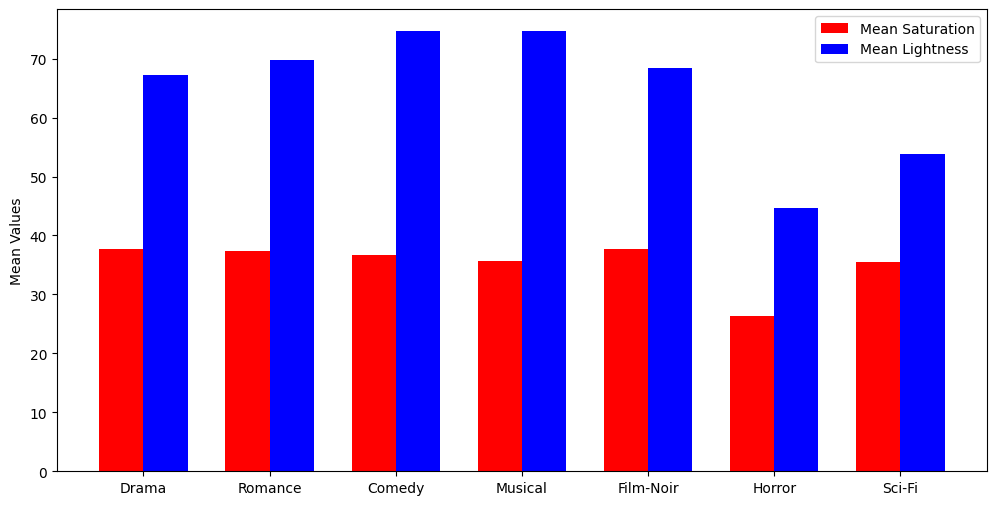

In [81]:
genre_list = ['Drama', 'Romance', 'Comedy', 'Musical', 
              'Film-Noir', 'Horror', 'Sci-Fi']
mean_saturation_values = []
mean_lightness_values = []

for genre in genre_list:
    genre_rows = combined[(combined['Genre1'] == genre) | 
                          (combined['Genre2'] == genre) | 
                          (combined['Genre3'] == genre)]
    saturation_values = [color[1] for color in genre_rows['Main Color (HSL)']]
    lightness_values = [color[2] for color in genre_rows['Main Color (HSL)']]
    mean_saturation = np.mean(saturation_values)
    mean_lightness = np.mean(lightness_values)
    mean_saturation_values.append(mean_saturation)
    mean_lightness_values.append(mean_lightness)

bar_width = 0.35
bar_positions = np.arange(len(genre_list))
fig, ax = plt.subplots(figsize=(12, 6))
ax.bar(bar_positions - bar_width/2, 
       mean_saturation_values, bar_width, 
       abel='Mean Saturation', color='red')
ax.bar(bar_positions + bar_width/2, 
       mean_lightness_values, bar_width, 
       label='Mean Lightness', color='blue')
ax.set_ylabel('Mean Values')
ax.set_xticks(bar_positions)
ax.set_xticklabels(genre_list)
ax.legend()